# Redes Neurais - Projeto 5
# Modelos Convolucionais - CNN
### Luis Filipe Menezes
#### RA: 164924

# Objetivos:

Este caderno consiste na quinta entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado.

O projeto tem como objetivo:

- Implementar uma rede CNN:
  - Usar MNIST, MNIST-Fashion, ou CIFAR-10 (ou outro dataset)

- Avaliar diferentes topologias (>5 topologias) e parâmetros
- Calcular a matriz de confusão para os dois melhores modelos
- Avaliar a diferença entre os modelos (top-2)

- Treinar uma rede MLP (já implementada no trabalho anterior) e
comparar com a rede CNN gerada: acurácia versus número de
parâmetros

# I. Importando e tratando o conjunto de dados:

Iremos utilizar o CIFAR-10

In [27]:
from keras.datasets import cifar10
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

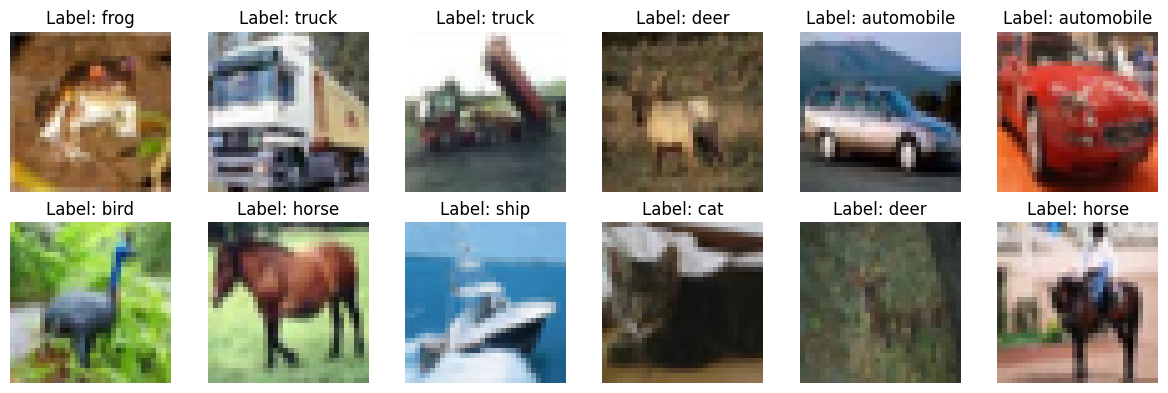

In [28]:
import matplotlib.pyplot as plt

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def display_images(images, labels_data, num_rows=2, num_cols=6):
    if num_rows * num_cols > len(images):
        print(f"Warning: Not enough images to fill a {num_rows}x{num_cols} grid. Displaying all available {len(images)} images.")
        num_to_display = len(images)
    else:
        num_to_display = num_rows * num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_to_display):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[labels_data[i][0]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display 6x2 subplots of the training dataset
display_images(train_images, train_labels, num_rows=2, num_cols=6)

In [29]:
import keras

images = keras.layers.Rescaling(scale=1./255)(train_images)

labels = keras.utils.to_categorical(train_labels, num_classes=10)

test_images_processed = keras.layers.Rescaling(scale=1./255)(test_images)

test_labels_categorical = keras.utils.to_categorical(test_labels, num_classes=10)

print("Test images processed shape:", test_images_processed.shape)
print("Test labels categorical shape:", test_labels_categorical.shape)

Test images processed shape: (10000, 32, 32, 3)
Test labels categorical shape: (10000, 10)


# II. Experimentando diferentes topologias:

Vamos treinar cada modelo por 50 épocas com um *EarlyStopping* de 5 épocas de paciência.

Para todas as camadas (densas e convolucionais) iremos utilizar a função de ativação ReLU e regularização L2.

Para todas as camadas convolucionais, iremos utilizar *maxPooling* de (2,2) ou seja, estamos diminuindo o campo receptivo local de cada mapa (de $32x32$ para $16x16$ na primeira camada por exemplo) e adicionando uma certa invariância local.

In [30]:
def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [31]:
import keras
from keras import layers
from keras import models

def build_train_evaluate_cnn(
    train_images_data, train_labels_data,
    test_images_data, test_labels_data,
    conv_layer_configs, # e.g., [{'filters': 32, 'kernel_size': (3,3), 'padding': 'valid', 'strides': (1,1)}]
    # dense_layer_units,  # e.g., [100] for one dense layer with 100 neurons
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    epochs=10,
    batch_size=32,
    input_shape=(32, 32, 3) # Default for CIFAR-10
):
    """
    Builds, compiles, trains, and evaluates a Keras CNN model.

    Args:
        train_images_data (np.array): Preprocessed training images.
        train_labels_data (np.array): One-hot encoded training labels.
        test_images_data (np.array): Preprocessed test images.
        test_labels_data (np.array): One-hot encoded test labels.
        conv_layer_configs (list): A list of dictionaries, each describing a Conv2D layer.
                                   Example: [{'filters': 32, 'kernel_size': (3,3), 'padding': 'valid', 'strides': (1,1)}]
        dense_layer_units (list): A list of integers, each representing the number of units
                                  in a Dense layer before the output layer.
        optimizer (str): Keras optimizer name (e.g., 'adam').
        loss (str): Keras loss function name (e.g., 'categorical_crossentropy').
        metrics (list): List of metrics to be evaluated by the model during training and testing.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        input_shape (tuple): The shape of the input images.

    Returns:
        tuple: A tuple containing:
            - history (keras.callbacks.History): Training history object.
            - test_loss (float): Loss value on the test dataset.
            - test_accuracy (float): Accuracy on the test dataset.
            - model (keras.models.Sequential): The trained Keras model.
    """
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))

    # Add convolutional layers
    for i, config in enumerate(conv_layer_configs):
        model.add(layers.Conv2D(
                filters=config.get('filters', 32),
                kernel_size=config.get('kernel_size', (3, 3)),
                padding=config.get('padding', 'valid'),
                strides=config.get('strides', (1, 1)),
                kernel_regularizer=keras.regularizers.l2(0.001),
                activation='relu'
                ))
        model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for dense layers
    model.add(layers.Flatten())

    # Add dense layers
    for units in conv_layer_configs[0].get('dense_config', [32]):
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))

    # Output layer (10 classes for CIFAR-10)
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)

    print("Topologia do modelo atual:")
    model.summary()

    # Train the model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=5,
                                                   restore_best_weights=True)

    history = model.fit(train_images_data, train_labels_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(test_images_data, test_labels_data),
                        callbacks=[early_stopping],
                        verbose=0) # Set verbose to 0 to avoid cluttering output during experiments

    plot_learning_curve(history)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_images_data, test_labels_data, verbose=0)

    print(f"Erro de teste: {test_loss:.4f}, Acurácia de teste: {test_accuracy:.4f}")

    return history, test_loss, test_accuracy, model

## Configuração dos experimentos:

Iremos experimentar 7 topologias:
1. 1 camada convolucional de 16 mapas, com kernel size de (3,3), sem *padding* seguido de uma camada densa de 64 neurônios.
2. 1 camada convolucional de 16 mapas, com kernel size de (3,3), com *zero-padding* seguido de uma camada densa de 64 neurônios.
3. 1 camada convolucional de 16 mapas, com kernel size de (3,3), com *zero-padding* e $stride=(2,2)$ seguido de uma camada densa de 64 neurônios.
4. 1 camada convolucional de 32 mapas, com kernel size de (3,3), com *zero-padding* seguido de uma camada densa de 64 neurônios.
5. 2 camadas convolucionais de 32 a 16 mapas, com kernel size de (5,5) a (3,3), com *zero-padding* seguido de uma camada densa de 64 neurônios.
6. 2 camadas convolucionais de 32 a 16 mapas, com kernel size de (5,5) a (3,3), com *zero-padding* seguido de duas camadas densas de 64 e 32 neurônios.
7. 3 camadas convolucionais de 32 a 32 a 16 mapas, com kernel size de (5,5) a (3,3) a (3,3), com *zero-padding* seguido de uma camada densa de 64 neurônios.

Model Summary for current topology:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │       230,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,562 (904.54 KB)

 Trainable params: 231,562 (904.54 KB)

 Non-trainable params: 0 (0.00 B)

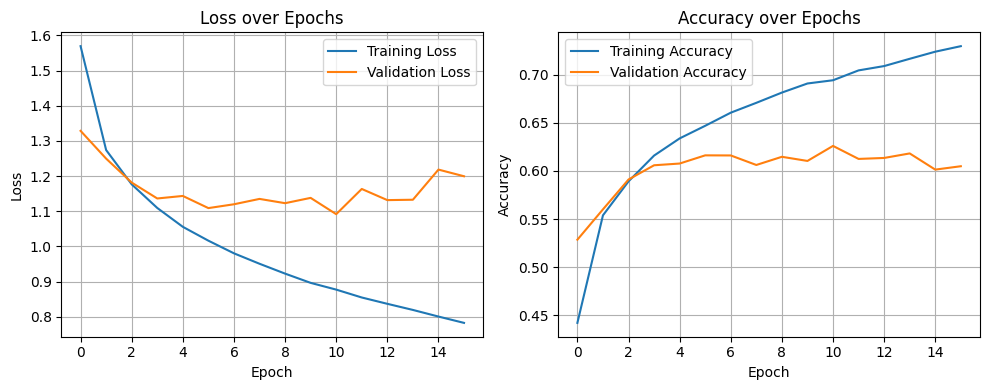

Test Loss: 1.0918, Test Accuracy: 0.6260
Model Summary for current topology:


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,306 (1.00 MB)

 Trainable params: 263,306 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

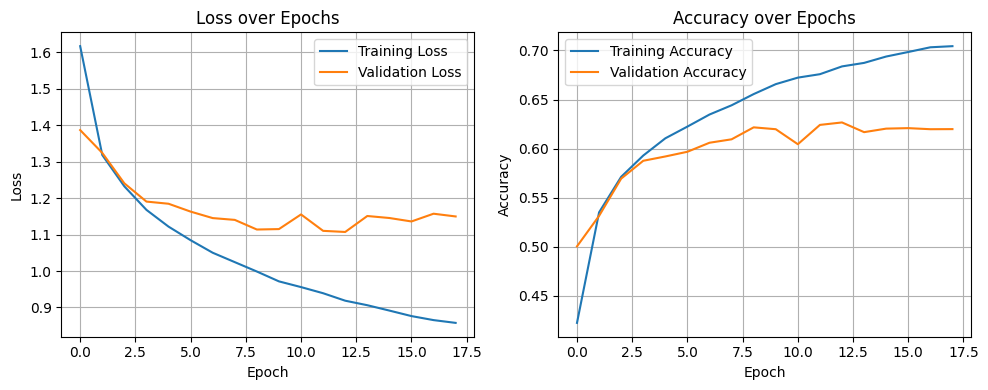

Test Loss: 1.1071, Test Accuracy: 0.6266
Model Summary for current topology:


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,698 (260.54 KB)

 Trainable params: 66,698 (260.54 KB)

 Non-trainable params: 0 (0.00 B)

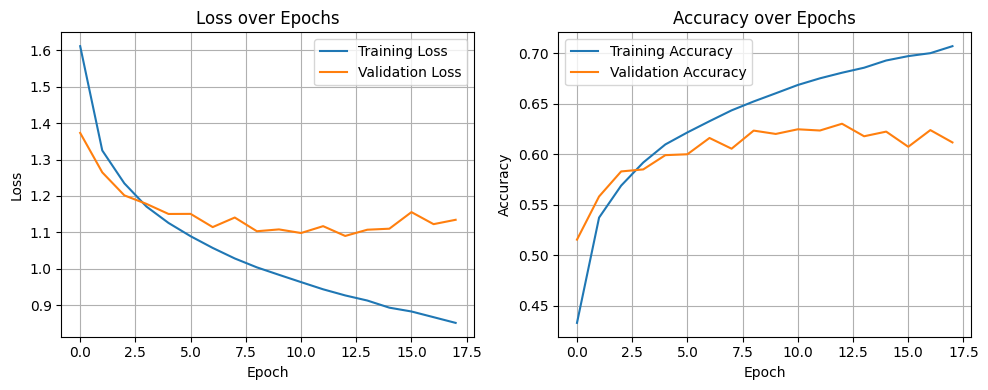

Test Loss: 1.0901, Test Accuracy: 0.6303
Model Summary for current topology:


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,898 (2.01 MB)

 Trainable params: 525,898 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

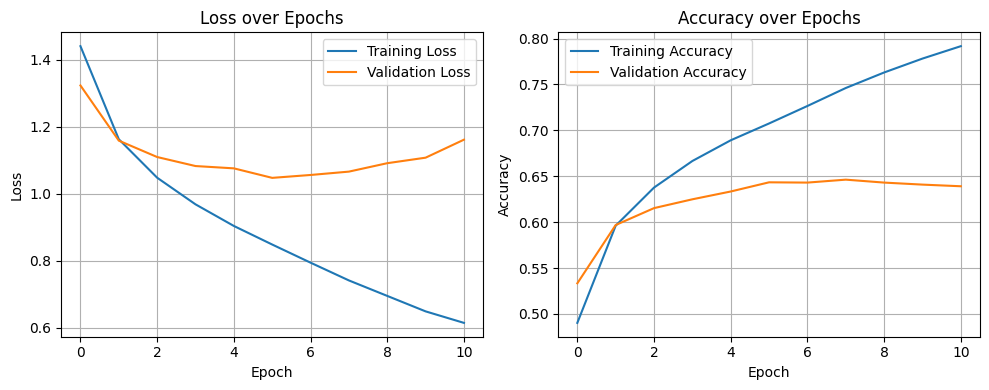

Test Loss: 1.0472, Test Accuracy: 0.6434
Model Summary for current topology:


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,306 (286.35 KB)

 Trainable params: 73,306 (286.35 KB)

 Non-trainable params: 0 (0.00 B)

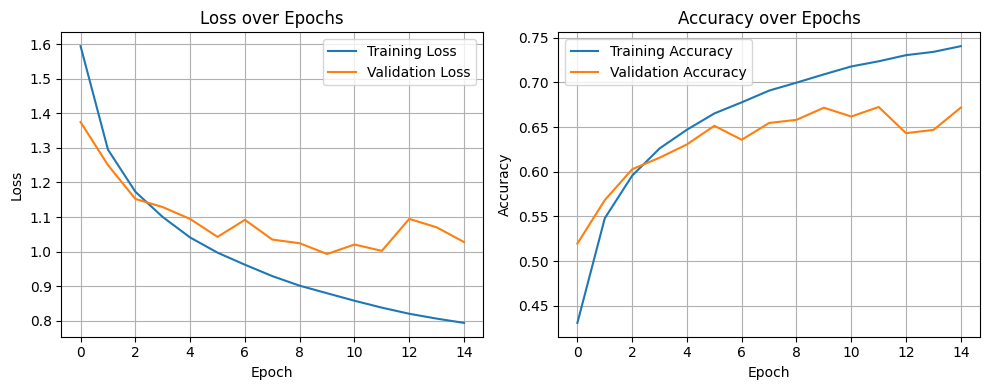

Test Loss: 0.9929, Test Accuracy: 0.6717
Model Summary for current topology:


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,066 (293.23 KB)

 Trainable params: 75,066 (293.23 KB)

 Non-trainable params: 0 (0.00 B)

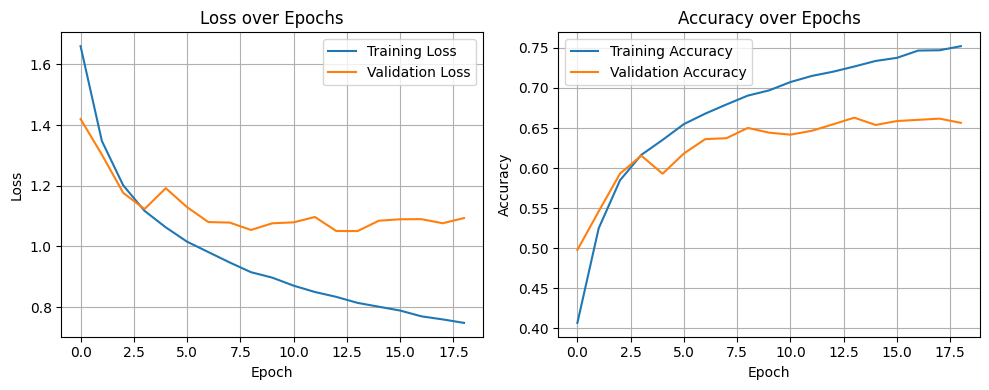

Test Loss: 1.0505, Test Accuracy: 0.6629
Model Summary for current topology:


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,402 (130.48 KB)

 Trainable params: 33,402 (130.48 KB)

 Non-trainable params: 0 (0.00 B)

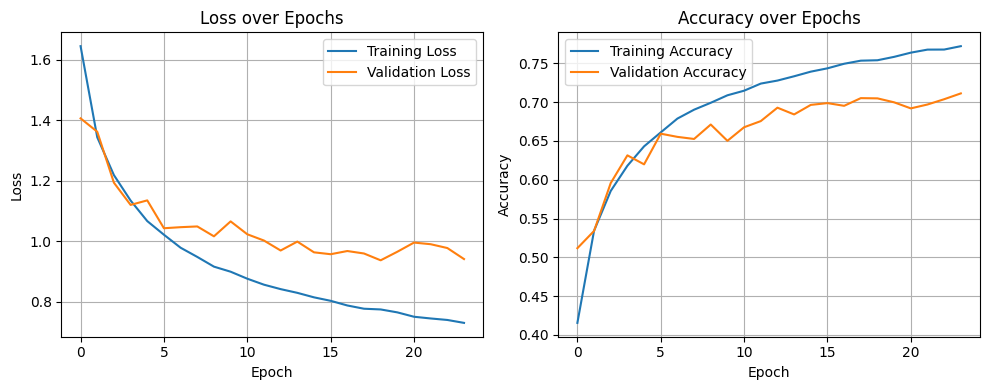

Test Loss: 0.9370, Test Accuracy: 0.7048


In [33]:
conv_configs = [[{'filters': 16, 'kernel_size': (3, 3), 'padding': 'valid', 'strides': (1, 1), 'dense_config': [64]}],
                 [{'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (1, 1), 'dense_config': [64]}],
                 [{'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (2, 2), 'dense_config': [64]}],
                 [{'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (1, 1), 'dense_config': [64]}],
                 [{'filters': 32, 'kernel_size': (5, 5), 'padding': 'same', 'strides': (1, 1), 'dense_config': [64]},
                  {'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (1, 1), 'dense_config': [64]}],
                 [{'filters': 32, 'kernel_size': (5, 5), 'padding': 'same', 'strides': (1, 1), 'dense_config': [64, 32]},
                  {'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (1, 1)}],
                 [{'filters': 32, 'kernel_size': (5, 5), 'padding': 'same', 'strides': (1, 1), 'dense_config': [64]},
                  {'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (1, 1)},
                  {'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'strides': (1, 1)}]
                 ]



log = []
for i, conv_config in enumerate(conv_configs):
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  history, test_loss, test_accuracy, model = build_train_evaluate_cnn(
      train_images_data=images,
      train_labels_data=labels,
      test_images_data=test_images_processed,
      test_labels_data=test_labels_categorical,
      conv_layer_configs=conv_config,
      # dense_layer_units=dense_config_1,
      epochs=50
  )
  log.append({'history': history,
              'test_loss': test_loss,
              'test_accuracy': test_accuracy,
              'model': model})

# 5. Print the test accuracy to record the model's performance for Topology 1
# print(f"Topology 1 Test Accuracy: {test_accuracy_1:.4f}")

## Comentários:

As configurações de *padding* e variações para camadas rasas não trouxeram ganho significativo na performance aliado à adição 30k parâmetros treináveis.

Aumentar o stride funciona como uma redução de dimensionalidade agressiva (dividindo pela metade o tamanho do mapa a ser entrada para as camadas densas). Isso tornou o modelo muito mais leve e eficiente sem perder poder preditivo. Menos parâmetros na camada densa significam menos chance de overfitting em modelos simples.

Outra coisa é em relação à profundidade X dimensionalidade. O modelo 31 (1 camada com 32 filtros) tem 525k parâmetros e acurácia de 0.64. O modelo 32 (2 camadas com 32 para 16 filtros) tem apenas 73k parâmetros e acurácia de 0.67. Isso mostra que adicionar uma segunda camada convolucional (com Pooling) é muito mais eficaz do que apenas aumentar o número de filtros em uma única camada.

# III. Calcular a matriz de confusão para os dois melhores modelos:

## Encontrar os melhores modelos:

In [34]:
sorted_log_by_accuracy = sorted(log, key=lambda x: x['test_accuracy'], reverse=True)

best_model_1 = sorted_log_by_accuracy[0]
best_model_2 = sorted_log_by_accuracy[1]

print(f"Acurácia de teste do 1° melhor modelo: {best_model_1['test_accuracy']:.4f}")
print(f"Acurácia de teste do 2° melhor modelo: {best_model_2['test_accuracy']:.4f}")

Best Model 1 Test Accuracy: 0.7048
Best Model 2 Test Accuracy: 0.6717


In [35]:
y_true = test_labels.flatten()
print(f"Shape of y_true: {y_true.shape}")
print(f"First 5 elements of y_true: {y_true[:5]}")

Shape of y_true: (10000,)
First 5 elements of y_true: [3 8 8 0 6]


In [36]:
import numpy as np

predictions_model_1 = best_model_1['model'].predict(test_images_processed)
y_pred_model_1 = np.argmax(predictions_model_1, axis=1)

print(f"Shape of predictions_model_1: {predictions_model_1.shape}")
print(f"Shape of y_pred_model_1: {y_pred_model_1.shape}")
print(f"First 5 predicted labels for Model 1: {y_pred_model_1[:5]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of predictions_model_1: (10000, 10)
Shape of y_pred_model_1: (10000,)
First 5 predicted labels for Model 1: [5 8 0 8 4]


In [37]:
predictions_model_2 = best_model_2['model'].predict(test_images_processed)
y_pred_model_2 = np.argmax(predictions_model_2, axis=1)

print(f"Shape of predictions_model_2: {predictions_model_2.shape}")
print(f"Shape of y_pred_model_2: {y_pred_model_2.shape}")
print(f"First 5 predicted labels for Model 2: {y_pred_model_2[:5]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of predictions_model_2: (10000, 10)
Shape of y_pred_model_2: (10000,)
First 5 predicted labels for Model 2: [3 8 8 8 3]


In [40]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(f"Class names defined: {class_names}")

Class names defined: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


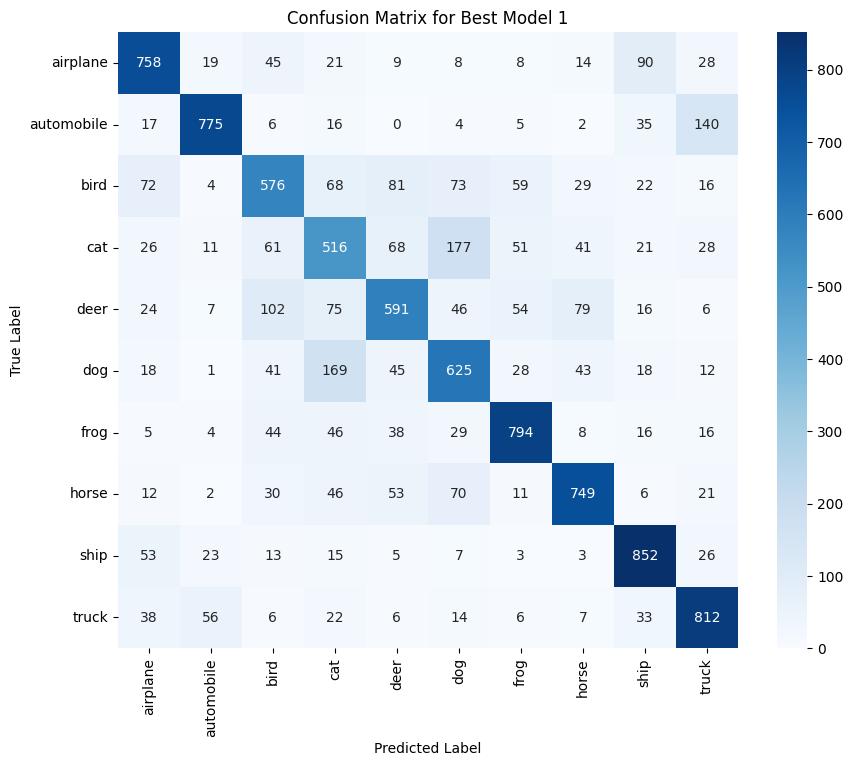

Confusion Matrix for Best Model 1:
[[758  19  45  21   9   8   8  14  90  28]
 [ 17 775   6  16   0   4   5   2  35 140]
 [ 72   4 576  68  81  73  59  29  22  16]
 [ 26  11  61 516  68 177  51  41  21  28]
 [ 24   7 102  75 591  46  54  79  16   6]
 [ 18   1  41 169  45 625  28  43  18  12]
 [  5   4  44  46  38  29 794   8  16  16]
 [ 12   2  30  46  53  70  11 749   6  21]
 [ 53  23  13  15   5   7   3   3 852  26]
 [ 38  56   6  22   6  14   6   7  33 812]]


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for Model 1
cm_model_1 = confusion_matrix(y_true, y_pred_model_1)

# Plot Confusion Matrix for Model 1
plt.figure(figsize=(10, 8))
sns.heatmap(cm_model_1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusão para o modelo 1')
plt.xlabel('Rótulos predito')
plt.ylabel('Rótulo real')
plt.show()

# print("Confusion Matrix for Best Model 1:")
# print(cm_model_1)

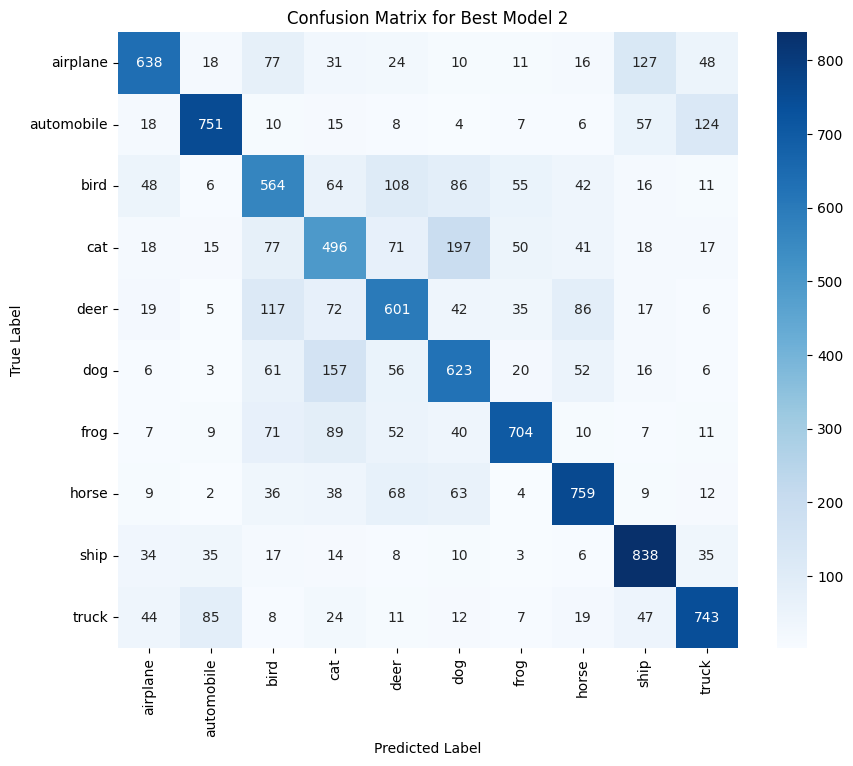

Confusion Matrix for Best Model 2:
[[638  18  77  31  24  10  11  16 127  48]
 [ 18 751  10  15   8   4   7   6  57 124]
 [ 48   6 564  64 108  86  55  42  16  11]
 [ 18  15  77 496  71 197  50  41  18  17]
 [ 19   5 117  72 601  42  35  86  17   6]
 [  6   3  61 157  56 623  20  52  16   6]
 [  7   9  71  89  52  40 704  10   7  11]
 [  9   2  36  38  68  63   4 759   9  12]
 [ 34  35  17  14   8  10   3   6 838  35]
 [ 44  85   8  24  11  12   7  19  47 743]]


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for Model 2
cm_model_2 = confusion_matrix(y_true, y_pred_model_2)

# Plot Confusion Matrix for Model 2
plt.figure(figsize=(10, 8))
sns.heatmap(cm_model_2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de confusão para modelo 2')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# print("Confusion Matrix for Best Model 2:")
# print(cm_model_2)

In [43]:
model1_correct = (y_pred_model_1 == y_true)
model2_correct = (y_pred_model_2 == y_true)

# print(f"Shape of model1_correct: {model1_correct.shape}")
print(f"Primeiros 5 elementos de model1_correct: {model1_correct[:5]}")
print(f"Shape of model2_correct: {model2_correct.shape}")
print(f"Primeiros 5 elementos de model2_correct: {model2_correct[:5]}")

Shape of model1_correct: (10000,)
First 5 elements of model1_correct: [False  True False False False]
Shape of model2_correct: (10000,)
First 5 elements of model2_correct: [ True  True  True False False]


In [44]:
both_correct = np.sum(model1_correct & model2_correct)
model1_correct_model2_incorrect = np.sum(model1_correct & ~model2_correct)
model1_incorrect_model2_correct = np.sum(~model1_correct & model2_correct)
both_incorrect = np.sum(~model1_correct & ~model2_correct)

print(f"Número de amostras onde os dois estão corretos: {both_correct}")
print(f"Número de amostras onde Modelo 1 está correto e modelo 2 está incorreto: {model1_correct_model2_incorrect}")
print(f"Número de amostras onde Modelo 1 está incorreto e modelo 2 está correto: {model1_incorrect_model2_correct}")
print(f"Número de amostras onde os dois modelos estão incorretos: {both_incorrect}")

# Verify that the sum equals the total number of test samples
total_samples = both_correct + model1_correct_model2_incorrect + model1_incorrect_model2_correct + both_incorrect
# print(f"Total samples: {total_samples} (should be {len(y_true)})")

Number of samples where both models are correct: 5821
Number of samples where Model 1 is correct and Model 2 is incorrect: 1227
Number of samples where Model 1 is incorrect and Model 2 is correct: 896
Number of samples where both models are incorrect: 2056
Total samples: 10000 (should be 10000)


In [ ]:
xlabels = ["Acerto", "Erro"]

cm = np.array((2,2))
cm[0][0] = both_correct
cm[0][1] = model1_correct_model2_incorrect
cm[1][0] = model1_incorrect_model2_correct
cm[1][1] = both_incorrect

plt.figure(figsize=(10, 8))
sns.heatmap(cm_model_2, annot=True, fmt='d', cmap='Blues', xticklabels=xlabels, yticklabels=xlabels)
plt.title('Matriz de confusão')
plt.xlabel('Modelo 1')
plt.ylabel('Modelo 2')
plt.show()

# IV. Comparando CNN com MLP

Queremos analisar a eficácia e eficiência da arquitetura CNN com a arquitetura MLP. Nossa hipótese é de que a CNN alcançará uma performance melhor utilizando menos parâmetros (ou seja, com menos custo computacional).

## Construindo uma MLP